<a href="https://colab.research.google.com/github/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/multi_material-CT_scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
#
#  Copyright 2024 United Kingdom Research and Innovation
#  Copyright 2024 Bangor University
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck Vidal (UKRI-STFC) & Iwan Mitchell (Bangor University)

![gVXR](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/img/Logo-transparent-small.png?raw=1)

<!-- # Multi-material example: Lungman phantom

In this notebook you will use the knowledge learned in [first_xray_simulation.ipynb](first_xray_simulation.ipynb) to set some of the simulation parameters.
We aim to **replicate a digital radiograph (DR)** of the [Lungman anthropomorphic chest phantom](https://doi.org/10.1117/1.JMI.5.1.013504) (Kyoto Kagaku, Tokyo, Japan) taken with a clinical X-ray machine by GE Healthcare (Chicago, Illinois, USA) at one of our local hospitals (Glan Clwyd). Parameters relevant to the simulation are extracted from the DICOM file, such as source-patient-distance and source-detector-distance.

![Photograph of the Lungman phantom during the digital radiograph acquisition](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/img/lungman-photo.jpg?raw=1)

Additionaly, we will **demonstrate how to use more than one material**.
We scanned the [Lungman anthropomorphic chest phantom](https://doi.org/10.1117/1.JMI.5.1.013504) at the same hospital (Ysbyty Gwynedd) using a 128-slice Somatom Definition Edge scanner by Siemens Healthcare (Erlangen, Germany).
The CT volume was then segmented into individual structures.
Surface meshes were eventually extracted from the segmented CT scan.
The corresponding data is available on [Zenodo](https://zenodo.org/records/10782644) (the notebook will download and extract the files automatically).
The material property of each anatomical structure is defined as the average Hounsfield unit of that structure.
Hounsfield values are then converted into material compositions (mixtures) and densities using [Schneider et al.'s method](https://doi.org/10.1088/0031-9155/45/2/314). This functionality is already built in gVXR.

<div class="alert alert-block alert-warning">
    <b>Note:</b> Make sure the Python packages are already installed. See <a href="../README.md">README.md</a> in the root directory of the repository. If you are running this notebook from Google Colab, please run the cell below to install the required packages.
</div> -->

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q condacolab
    import condacolab
    condacolab.install()

    !conda install -y -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=24.2.0 ipp=2021.12 astra-toolbox=*=cuda* tigre k3d
    !pip install gvxr viewscad

    import os, urllib.request

    if not os.path.exists("../data/Wire-Cu-2mm-17.54umvx"):
        os.makedirs("../data/Wire-Cu-2mm-17.54umvx");

    files = ["../data/Wire-Cu-2mm-17.54umvx/img_00000.tif",
            "notebooks/gvxr2json.py",
            ];

    url = "https://github.com/TomographicImaging/gVXR-Tutorials/raw/refs/heads/main/../data/Wire-Cu-2mm-17.54umvx/img_00000.tif";
    print("Download", url)
    urllib.request.urlretrieve(url, "../data/Wire-Cu-2mm-17.54umvx/img_00000.tif");

    url = "https://github.com/TomographicImaging/gVXR-Tutorials/raw/refs/heads/main/notebooks/gvxr2json.py";
    print("Download", url)
    urllib.request.urlretrieve(url, "gvxr2json.py");

## Aims of this session

<!-- 1. Practice, amongst other things, how to set simulation parameters related to the X-ray source and detector;
2. Demonstrate how to load several STL files and use them all in the simulation (multi-material).
 -->
![Screenshot of the 3D environment using K3D](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/output_data/multi_material-CT_scan/k3d_screenshot-cropped.png?raw=1)

## Summary of the simulation parameters
<!--
| Parameters | Values | Units | Function call |
|------------|--------|-------|---------------|
| Source to patient distance | 1751 | mm | `gvxr.setSourcePosition(...)` |
| Source type (beam shape) | Point source (cone beam) | | `gvxr.usePointSource()` |
| Beam spectrum | Monochromatic: 16,000 photons of 90 | keV | `gvxr.setMonoChromatic(...)` |
| Source to detector distance | 1800 | mm | `gvxr.setDetectorPosition(...)` |
| Detector orientation | [0, 0, -1] |  | `gvxr.setDetectorUpVector(...)` |
| Detector resolution | 1871 &times; 1881 | pixels | `gvxr.setDetectorNumberOfPixels(...)` |
| Pixel spacing | 0.2 &times; 0.2 | mm | `gvxr.setDetectorPixelSize(...)` | -->

## Import packages
<!--
- `os` to create the output directory if needed
- `matplotlib` to show 2D images
- `viewscad` to use OpenSCAD and create STL files
- `gvxrPython3.gvxr` to simulate X-ray images
- `tifffile.imread`
- `gvxrPython3.gvxr2json` to save the state of the simulation in JSON file
- `JSON2gVXRDataReader` to read the simulated data and prepare it for CIL
    from cil.processors import Transmiss
    from cil.recon
  import FBP, FDK
ionAbsorptionConverter
    from cil.utilities.display import show_geometry, show2D
    from cil.utilities.jupyter import islicer, link_islicer
TIFFWriter
 -->

In [3]:
import os # Create the output directory if necessary
import numpy as np # Who does not use Numpy?

import matplotlib # To plot images
import matplotlib.pyplot as plt # Plotting

font = {'family' : 'serif',
         'size'   : 15
       }
matplotlib.rc('font', **font)

# Uncomment the line below to use LaTeX fonts
# matplotlib.rc('text', usetex=True)

import viewscad # Use OpenSCAD to create STL files

import base64

from tifffile import imread


from gvxrPython3 import gvxr
from gvxrPython3.utils import visualise

# Use temporary bug fix
if os.path.exists("gvxr2json.py"):
    print("Use temporary bug fix")
    import gvxr2json
#Use the file provided by gVXR's package
else:
    print("Use the file provided by gVXR's package")
    from gvxrPython3 import gvxr2json

from gvxrPython3.JSON2gVXRDataReader import *

from cil.recon import FDK # For CBCT
from cil.recon import FBP # For parallel beam geometry

from cil.io import TIFFWriter

from cil.processors import TransmissionAbsorptionConverter
from cil.utilities.display import show_geometry, show2D
from cil.utilities.jupyter import islicer, link_islicer


spekpy is not install, you won't be able to load a beam spectrum using spekpy
xpecgen is not install, you won't be able to load a beam spectrum using xpecgen
Use temporary bug fix


In [4]:
raw_reference = np.array(imread("../data/Wire-Cu-2mm-17.54umvx/img_00000.tif"), dtype=np.single);
raw_reference /= raw_reference.max()

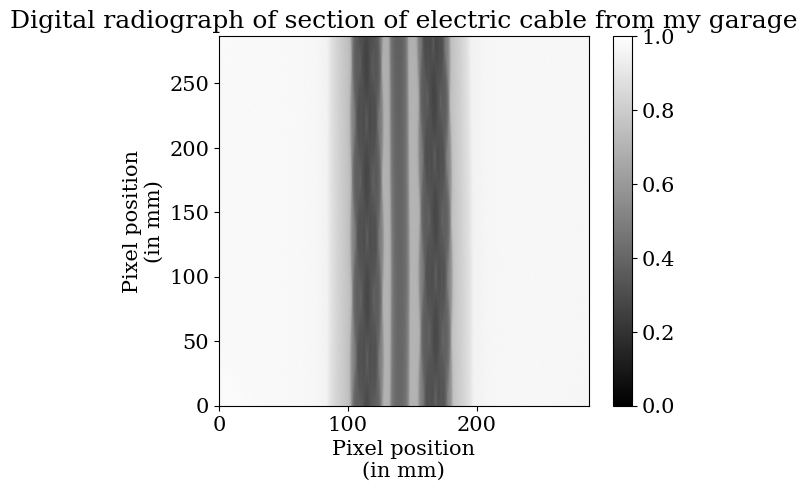

In [5]:
imager_pixel_spacing = [0.15, 0.15];
vmin=0.0;
vmax=1.0;

fig = plt.figure();
plt.imshow(raw_reference, cmap="gray", vmin=vmin, vmax=vmax,
                             extent=[0,(raw_reference.shape[1]-1)*imager_pixel_spacing[0],0,(raw_reference.shape[0]-1)*imager_pixel_spacing[1]])
plt.title("Digital radiograph of section of electric cable from my garage")
plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.colorbar()
plt.show()

## Getting the data ready

In [6]:
output_path = "output_data/multi_material-CT_scan"
if not os.path.exists(output_path):
    os.makedirs(output_path);

In [7]:
scad_function_string = """

height = 100;
twist = 0;

module wire_strand (height, twist)
{
    union()
    {
        linear_extrude(height = height, center = true, convexity = 10, twist = 0)
        translate([0, 0, 0])
        circle(r = 1, $fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([2, 0, 0])
        circle(r = 1,$fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([-2, 0, 0])
        circle(r = 1,$fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([-1, 1.72, 0])
        circle(r = 1,$fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([1, 1.72, 0])
        circle(r = 1,$fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([-1, -1.72, 0])
        circle(r = 1,$fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([1, -1.72, 0])
        circle(r = 1,$fn = 100);
    }
}

module wires (height, twist)
{
    union ()
    {
        // Ground wire
        linear_extrude(height = height, center = true, convexity = 10, twist = 0)
        translate([0, 0, 0])
        circle(r = 2, $fn = 100);

        // Twisted wires
        translate([8, 0, 0])
        wire_strand(height, twist);

        translate([-8, 0, 0])
        wire_strand(height, twist);
    }
}

""";

In [8]:
"scad_wire_str = """
    wires (height + 20, twist);
""";

wire_fname_stl = os.path.join(output_path, "wires.stl");

if not os.path.exists(wire_fname_stl):
    r = viewscad.Renderer()
    r.render(scad_function_string + scad_wire_str, outfile=wire_fname_stl)

Exception: openscad exec not found!

In [ ]:
scad_plastic_sheath_str = """
    difference()
    {
        linear_extrude(height = height+1, center = true, convexity = 10, twist = 0)
            translate([0, 0, 0])
            resize([30,10])circle(r=13, $fn= 100);
        wires (height, twist);
    }
""";

insulation_fname_stl = os.path.join(output_path, "insulation.stl");

if not os.path.exists(insulation_fname_stl):
    r = viewscad.Renderer()
    r.render(scad_function_string + scad_plastic_sheath_str, outfile=insulation_fname_stl)

In [ ]:
# Create an OpenGL context
gvxr.createOpenGLContext();

# We increase the size of the visualisation framebuffer to generate higher resolution screenshots. It does not affect the simulation.
gvxr.setWindowSize(1000, 1000)

In [ ]:
# Set the X-ray source position and shape
gvxr.setSourcePosition(0.0, 60.0, 0.0, "mm");
gvxr.usePointSource();

# Set the Spectrum
gvxr.setMonoChromatic(100, "keV", 16000); # 100 keV is about the average photon energy

In [ ]:
# Set the detector properties
gvxr.setDetectorPosition(0.0, -580, 0.0, "mm");
gvxr.setDetectorUpVector(0, 0, 1);
gvxr.setDetectorNumberOfPixels(1912, 1912);
gvxr.setDetectorPixelSize(imager_pixel_spacing[0], imager_pixel_spacing[1], "mm");

In [ ]:
import math
print(round(2.0 * math.pi / math.atan((2.0 / gvxr.getDetectorNumberOfPixels()[0]))));

# print(gvxr.getOptimalNumberOfProjectionsCT())

## 5. Set the Sample

A sample is define by its geometry (surface) and material composition. Note that you can transform (translate, scale and rotate) a sample.

In [ ]:
gvxr.removePolygonMeshesFromSceneGraph();

geometry_set = {
    "wires": {"fname": wire_fname_stl, "Element": "Cu", "Colour" : [0.722, 0.451, 0.20, 1.0]},
    # "stealh": {"fname": insulation_fname_stl, "Element": "Cu", "Colour" : [0.722, 0.451, 0.20, 1.0]},
   "stealh": {"fname": insulation_fname_stl, "Compound": "C2H3Cl", "Density" : 1.3, "Colour" : [0.5, 0.5, 0.5, 1.0]},
}

translation_vector_in_mm = [0.0, -100.0, 0.0];

for label in geometry_set:
    gvxr.loadMeshFile(label, geometry_set[label]["fname"], "mm");

    # Chemical element
    if "Element" in geometry_set[label]:
        gvxr.setElement(label, geometry_set[label]["Element"]);
    # Compound + density
    elif "Compound" in geometry_set[label] and "Density" in geometry_set[label]:
        gvxr.setCompound(label, geometry_set[label]["Compound"]);
        gvxr.setDensity(label, geometry_set[label]["Density"], "g/cm3");
    # Mixture + density
    elif "Mixture" in geometry_set[label] and "Density" in geometry_set[label]:
        gvxr.setMixture(label, geometry_set[label]["Mixture"]);
        gvxr.setDensity(label, geometry_set[label]["Density"], "g/cm3");
    # Hounsfield unit
    elif "HU" in geometry_set[label]:
        gvxr.setHounsfieldUnit(label, round(geometry_set[label]["HU"]));
    # Unsupported
    else:
        raise ValueError("Unknow material composition for " + label + " in " + str(geometry_set[label]))

    # Colour in the 3D visualisation
    if "Colour" in geometry_set[label]:
        gvxr.setColour(label,
            geometry_set[label]["Colour"][0],
            geometry_set[label]["Colour"][1],
            geometry_set[label]["Colour"][2],
            geometry_set[label]["Colour"][3]);

    gvxr.translateNode(label, *translation_vector_in_mm, "mm");

In [ ]:
x_ray_image = np.array(gvxr.computeXRayImage(), dtype=np.single) / gvxr.getTotalEnergyWithDetectorResponse();
# gvxr.setZoom(500)
gvxr.displayScene()

# gvxr.renderLoop()

## Visualisation of the results

Keep in mind that clinical devices implement built-in image post-processing algorithms that change the pixel values. Specifics of these algorithms are unknown. We post-process our simulated X-ray image to display the image in a similar fashion using:

$$(-\log((Img + shift_1) \times scale_1) + shift_2) \times scale_2$$

Values of $shift_1$, $scale_1$, $shift_2$ and $scale_2$ have been calibrated.

In [ ]:
vmin = 0.0;
vmax = 1.0;

# Plot the two images side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))

im1 = axes.flat[0].imshow(raw_reference, cmap="gray", vmin=vmin, vmax=vmax,
    extent=[0,(raw_reference.shape[1]-1)*imager_pixel_spacing[0],0,(raw_reference.shape[0]-1)*imager_pixel_spacing[1]])
axes.flat[0].set_title("Ground truth")


im2 = axes.flat[1].imshow(x_ray_image, cmap="gray", vmin=vmin, vmax=vmax,
    extent=[0,(x_ray_image.shape[1]-1)*gvxr.getDetectorPixelSpacing("mm")[0],0,(x_ray_image.shape[0]-1)*gvxr.getDetectorPixelSpacing("mm")[1]])
axes.flat[1].set_title("gVirtualXRay")

axes.flat[0].set_xlabel("Pixel position\n(in mm)")
axes.flat[1].set_xlabel("Pixel position\n(in mm)")
axes.flat[0].set_ylabel("Pixel position\n(in mm)")

cb_ax = fig.add_axes([0.925, 0.35, 0.02, 0.275])
cbar = fig.colorbar(im1, cax=cb_ax)
plt.show()

It may be useful to visualise the 3D environment to ascertain everything is as expected. It can be done in a window or offscreen with a screenshot.
We use both the functionality built in gVXR and K3D

We use k3D if possible. It's a nice 3D visualisation framework for Jupyter notebooks.

In [ ]:
plot = visualise(use_log=True, use_negative=True, sharpen_ksize=2, sharpen_alpha=1.0);

if plot:
    plot.display();

In [ ]:
if plot:
    plot.fetch_screenshot();

In [ ]:
if plot:
    k3d_screenshot = plot.screenshot;
    data = base64.b64decode(k3d_screenshot);
    with open(os.path.join(output_path, "k3d_screenshot.png"), "wb") as fp:
        fp.write(data);
        fp.flush();
        fp.close();

## Compute the X-ray projections for a CT acquisition

In [ ]:
number_of_projections = 200;

gvxr.computeCTAcquisition(os.path.join(output_path, "projections-" + str(number_of_projections)), # the path where the X-ray projections will be saved.
                                                                    # If the path is empty, the data will be stored in the main memory, but not saved on the disk.
                                                                    # If the path is provided, the data will be saved on the disk, and the main memory released.
                          os.path.join(output_path, "screenshots-" + str(number_of_projections)), # the path where the screenshots will be saved.
                                                                    # If kept empty, not screenshot will be saved.
                          number_of_projections, # The total number of projections to simulate.
                          0, # The rotation angle corresponding to the first projection.
                          True, # A boolean flag to include or exclude the last angle. It is used to calculate the angular step between successive projections.
                          360,
                          0, # The number of white images used to perform the flat-field correction. If zero, then no correction will be performed.
                          *translation_vector_in_mm, # The location of the rotation centre.
                          "mm", # The corresponding unit of length.
                          *gvxr.getDetectorUpVector(), # The rotation axis
                          True, # If true the energy fluence is returned, otherwise the number of photons is returned
                                # (default value: true)
                          1 # The verbose level. If greater than zero, details will be outputed (default value = 0)
);

In [ ]:
# Save the current simulation states in a JSON file.
# It could be used to re-run the simulation, or to read the data with CIL.
json_fname = os.path.join(output_path, "simulation-" + str(number_of_projections) + ".json");
gvxr2json.saveJSON(json_fname);

In [ ]:
# Read the simulated data with CIL.
reader = JSON2gVXRDataReader(json_fname);
# reader = gVXRDataReader(gvxr.getProjectionOutputPathCT(), gvxr.getAngleSetCT(), gvxr.getCentreOfRotationPositionCT("mm"));
data = reader.read()

In [ ]:
print("data.geometry", data.geometry)

In [ ]:
show2D(data)

In [ ]:
islicer(data)

In [ ]:
data_corr = TransmissionAbsorptionConverter(white_level=data.max())(data)

In [ ]:
show2D(data_corr)

In [ ]:
islicer(data_corr)

In [ ]:
data_corr.reorder(order='tigre')

In [ ]:
ig = data_corr.geometry.get_ImageGeometry()

print("Initial image geometry", ig)

scaling_factor = 4
ig.voxel_num_x //= scaling_factor
ig.voxel_num_y //= scaling_factor
ig.voxel_num_z //= scaling_factor

ig.voxel_size_x *= scaling_factor
ig.voxel_size_y *= scaling_factor
ig.voxel_size_z *= scaling_factor

In [ ]:
print("Final image geometry", ig)

In [ ]:
# Perform the reconstruction with CIL
FDK_reconstruction = FDK(data_corr, ig).run()

In [ ]:
# Look at partial view artefacts
show2D(FDK_reconstruction, slice_list=[0, FDK_reconstruction.shape[0] // 2, FDK_reconstruction.shape[0] - 1], title=["1st slice", "Middle slice", "Last slice"], num_cols=3)

In [ ]:
islicer(FDK_reconstruction, minmax=None)

In [ ]:
# Save the reconstructed CT images
writer = TIFFWriter(data=FDK_reconstruction, file_name=os.path.join(output_path, "recons-" + str(number_of_projections), "slice_"), compression="uint16");
writer.write();

# Cleaning up

Once we have finished it is good practice to clean up the OpenGL contexts and windows with the following command.

In [ ]:
# gvxr.terminate();